## Analysis and Modeling of Exercise Images with Pose Estimation from MediaPipe and OpenCV

This notebook will delve into the analysis and modeling of various exercise images using different python libraries, including mediapipe, openCV, and pandas.

In [120]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

#read data and take a look
df = pd.read_csv('imagePoses.csv')
df.head()


,imageName,base64encoded,imageWidth,imageHeight,poseLandmarks,excercise
0,full-body-person-doing-pushup0.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQERMT...,183,275,"['x: 0.7909860014915466,y: 0.2797396183013916,...",pushup
1,full-body-person-doing-pushup1.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgW...,244,206,"['x: 0.5600898265838623,y: 0.5534414052963257,...",pushup
2,full-body-person-doing-pushup10.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRUW...,167,302,"['x: 0.4751896560192108,y: 0.4453135132789612,...",pushup
3,full-body-person-doing-pushup100.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgW...,183,275,"['x: 0.4743218421936035,y: 0.5276893377304077,...",pushup
4,full-body-person-doing-pushup101.jpeg,b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIREhUT...,225,225,NaN,pushup


### Here is an example of the images used:

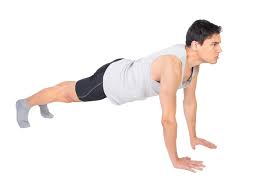

In [121]:
from base64 import b64decode
from IPython import display

#decode from base64
imgB64 = df['base64encoded'][0][2:]
imgStr = b64decode(imgB64)
display.Image(imgStr)

### An example of the image with the pose estimation:

In [122]:
#function to clean landmarks
def cleanPLs(lm):
    a = lm.replace("'", '').replace('"', '').strip('][').split(',')
    while ('' in a):
        a.remove('')
    cleanLM = []
    for i in range(0, len(a) - 4, 4):
        a[i] = a[i].strip()
        cleanLM.append([a[i], a[i+1], a[i+2], a[i+3]])
    return cleanLM

cleanLandmarks = cleanPLs(df['poseLandmarks'][0])
cleanLandmarks[:5]

[['x: 0.7909860014915466',
  'y: 0.2797396183013916',
  'z: -0.7337014675140381',
  'visibility: 0.9999721050262451'],
 ['x: 0.786137580871582',
  'y: 0.24491778016090393',
  'z: -0.699945330619812',
  'visibility: 0.999929666519165'],
 ['x: 0.7857223749160767',
  'y: 0.2434578835964203',
  'z: -0.6998971700668335',
  'visibility: 0.9999117851257324'],
 ['x: 0.7850363254547119',
  'y: 0.2417711317539215',
  'z: -0.7000457644462585',
  'visibility: 0.9999598264694214'],
 ['x: 0.7788354158401489',
  'y: 0.24451936781406403',
  'z: -0.7689036726951599',
  'visibility: 0.9999768733978271']]

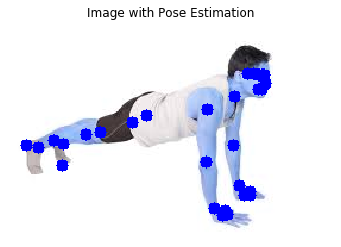

In [123]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

#convert from bytestring to cv image
nparr = np.fromstring(imgStr, np.uint8)
imgPose = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

#loop thru landmarks
for lm in cleanLandmarks:
    h, w, c = imgPose.shape
    #strip digits and convert to x, y floats
    x = float(lm[0].replace('x: ', ''))
    y = float(lm[1].replace('y: ', ''))
    #multiply and create shapes on image
    cx, cy = int(x*w), int(y*h)
    cv2.circle(imgPose, (cx, cy), 5, (0,0,255), cv2.FILLED)

plt.imshow(imgPose)
plt.title('Image with Pose Estimation')
plt.axis('off')
plt.show()

As we can see, the image can be reproduced from the data, and its pose estimation can be visualized. No need for additional data, just some tweaking.
<hr>

### Removing null values:

In [124]:
#look at how many nulls there are
df.isna().sum()

imageName          0
base64encoded      0
imageWidth         0
imageHeight        0
poseLandmarks    860
excercise          0
dtype: int64

In [125]:
#drop nullities
df = df.dropna()

In [126]:
df.isna().sum()

imageName        0
base64encoded    0
imageWidth       0
imageHeight      0
poseLandmarks    0
excercise        0
dtype: int64

In [134]:
#have a look at the number of different exercises
df['excercise'].value_counts()

lunges            333
squat             330
plank             320
pullup            315
pushup            309
shoulder press    286
chest dips        272
bent over row     246
glute bridge      230
Name: excercise, dtype: int64

<hr>

In [127]:
#clean all pose landmarks
df['poseLandmarks'] = df['poseLandmarks'].apply(lambda x : cleanPLs(x))

Create a new column storing the pose landmarks value as floats. This will make modeling much easier:

In [221]:
#create new column of only float values
def poseToFloats(lm):
    res = []
    for i in lm:
        x = float(i[0].replace('x: ', ''))
        y = float(i[1].replace('y: ', ''))
        z = float(i[2].replace('z: ', ''))
        v = float(i[3].replace('visibility: ', ''))
        res.append(x)
        res.append(y)
        res.append(z)
        res.append(v)
    return res
    
#add new column
df['poseAsFloats'] = df['poseLandmarks'].apply(lambda x : poseToFloats(x))
df['poseAsFloats'].head()

0    [0.7909860014915466, 0.2797396183013916, -0.73...
1    [0.5600898265838623, 0.5534414052963257, 0.032...
2    [0.4751896560192108, 0.4453135132789612, -0.55...
3    [0.4743218421936035, 0.5276893377304077, -0.40...
5    [0.7754234671592712, 0.4600318968296051, -0.41...
Name: poseAsFloats, dtype: object

<hr>

### Beginning modeling

First, let's do train/test split:

In [222]:
#function to encode target
def exerciseToInt(x):
    if x == 'pushup':
        x = 0
    elif x == 'bent over row':
        x = 1
    elif x == 'chest dips':
        x = 2
    elif x == 'glute bridge':
        x = 3
    elif x == 'lunges':
        x = 4
    elif x == 'plank':
        x = 5
    elif x == 'pullup':
        x = 6
    elif x == 'shoulder press':
        x = 7
    elif x == 'squat':
        x = 8
    return x

In [223]:
#create columns for poses data
col = []
for i in range(32):
    col.append('x_data' + str(i))
    col.append('y_data' + str(i))
    col.append('z_data' + str(i))
    col.append('v_data' + str(i))

df_enc = pd.DataFrame(df['poseAsFloats'].to_list(), columns=col)

#feature
feature = df_enc
#target
target = df['excercise'].apply(lambda x : exerciseToInt(x))

In [224]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=1)
# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training target:', y_train.shape)
print('Shape of testing target:', y_test.shape)

Shape of training feature: (2112, 128)
Shape of testing feature: (529, 128)
Shape of training target: (2112,)
Shape of testing target: (529,)


<hr>

A function to evaluate our model, thanks to Rafi Atha, his article is at: https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b

In [225]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average='micro')
    rec = metrics.recall_score(y_test, y_pred, average='micro')
    f1 = metrics.f1_score(y_test, y_pred, average='micro')
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    auc = 0# metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'auc': auc, 'cm': cm}

<hr>

In [232]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Building Random Forest model 
rf_grids = RandomForestClassifier(random_state=0)
# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


{'max_depth': 50,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [231]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.776937618147448
Precision: 0.776937618147448
Recall: 0.776937618147448
F1 Score: 0.776937618147448
Cohens Kappa Score: 0.7486844806969937
Area Under Curve: 0
Confusion Matrix:
 [[54  1  0  0  0  2  0  0  0]
 [ 0 41  6  0  0  2  0  0  2]
 [ 1  4 44  1  1  0  0  0  0]
 [ 1  2  1 36  6  4  0  0  1]
 [ 0  0  0  3 39  3  0  0 13]
 [ 2  2  0  7  0 55  0  0  0]
 [ 1  0  1  0  0  0 48 12  0]
 [ 0  1  2  0  0  0 11 42  2]
 [ 2  2  7  0  8  1  1  2 52]]
